In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
# Create the .kaggle directory for API credentials
!mkdir ~/.kaggle

# Copy the kaggle.json file to the appropriate location
!cp kaggle.json ~/.kaggle/

# Set permissions on the kaggle.json file
!chmod 600 ~/.kaggle/kaggle.json

# Download the APTOS 2019 dataset from Kaggle
!kaggle datasets download -d mariaherrerot/aptos2019

# Unzip the downloaded dataset
!unzip aptos2019.zip -d ./aptos2019


In [ ]:
import os
import pandas as pd
from PIL import Image
from torchvision import transforms
import torch
from torch.utils.data import DataLoader, Dataset

# Define the custom Dataset class for diabetic retinopathy data
class DiabeticRetinopathyDataset(Dataset):
    def __init__(self, df, img_dir, transform=None):
        """
        df: DataFrame containing image names and labels
        img_dir: Directory where images are stored
        transform: Image transformations to apply (resize, normalize, etc.)
        """
        self.df = df
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        # Fetch the image name and its corresponding label from the DataFrame
        img_name = self.df.iloc[idx, 0] + '.png'  # Assuming first column is image name (without extension)
        img_path = os.path.join(self.img_dir, img_name)

        # Load the image
        if os.path.exists(img_path):
            image = Image.open(img_path).convert('RGB')  # Open the image
        else:
            raise FileNotFoundError(f"Image {img_path} not found.")

        # Fetch the label (assuming second column is the label)
        label = self.df.iloc[idx, 1]

        # Apply transformations, if any
        if self.transform:
            image = self.transform(image)

        return image, label

# Define transformations (Resize and normalize for Vision Transformer)
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Vision Transformer input size
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load the CSVs for training, validation, and testing
data_path = "./aptos2019"
train_df = pd.read_csv(os.path.join(data_path, 'train_1.csv'))  # Training CSV
val_df = pd.read_csv(os.path.join(data_path, 'valid.csv'))      # Validation CSV
test_df = pd.read_csv(os.path.join(data_path, 'test.csv'))      # Test CSV

# Create dataset instances for train, validation, and test sets /kaggle/working/aptos2019
train_dataset = DiabeticRetinopathyDataset(train_df, os.path.join(data_path, 'train_images/train_images'), transform=transform)
val_dataset = DiabeticRetinopathyDataset(val_df, os.path.join(data_path, 'val_images/val_images'), transform=transform)
test_dataset = DiabeticRetinopathyDataset(test_df, os.path.join(data_path, 'test_images/test_images'), transform=transform)

# Create DataLoaders for batch processing
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)



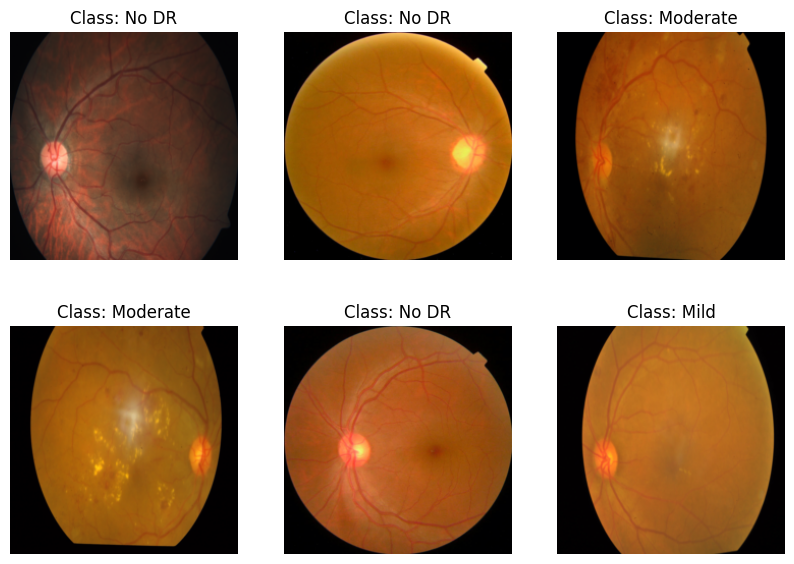

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torchvision
from torchsummary import summary
import numpy as np

# Function to visualize sample images
def show_sample_images(dataloader, class_names):
    images, labels = next(iter(dataloader))  # Get a batch of images
    images = images[:6]  # Select 6 images
    labels = labels[:6]

    fig, axes = plt.subplots(2, 3, figsize=(10, 7))
    for i, ax in enumerate(axes.flat):
        img = images[i].permute(1, 2, 0).numpy()  # Convert tensor to numpy
        img = img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])  # Unnormalize
        img = np.clip(img, 0, 1)  # Clip values to be in valid range
        ax.imshow(img)
        ax.set_title(f"Class: {class_names[labels[i].item()]}")
        ax.axis("off")

    plt.show()

# Function to plot class distribution
def plot_class_distribution(df, title):
    plt.figure(figsize=(6, 4))
    sns.countplot(x=df.iloc[:, 1], palette="viridis")
    plt.xlabel("Class")
    plt.ylabel("Count")
    plt.title(title)
    plt.show()

# Define class names for diabetic retinopathy severity (modify if different)
class_names = ["No DR", "Mild", "Moderate", "Severe", "Proliferative DR"]

# Show sample images from the training dataset
show_sample_images(train_loader, class_names)



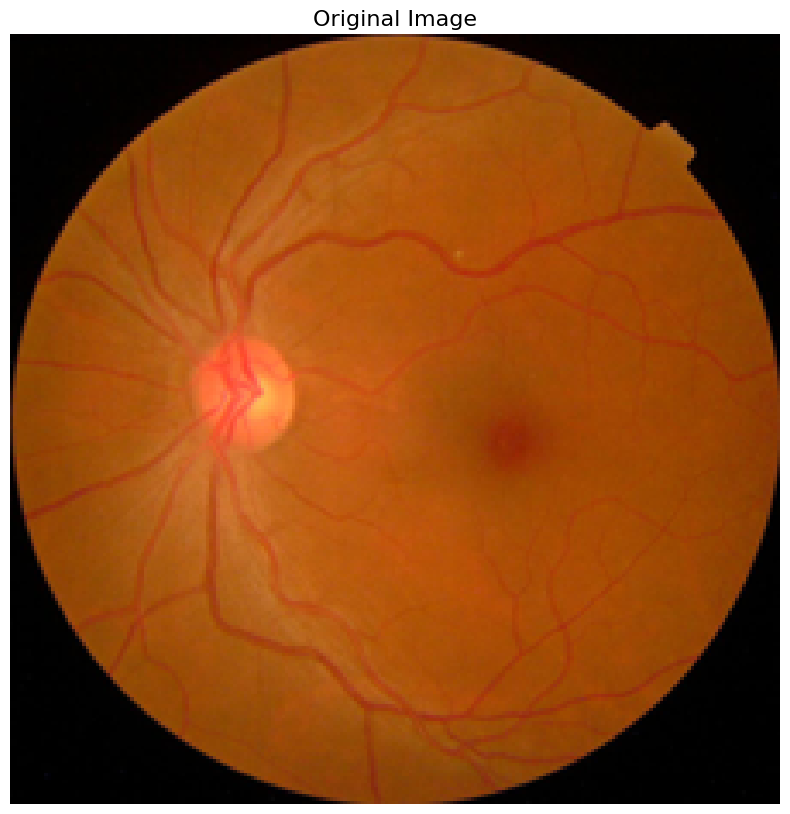

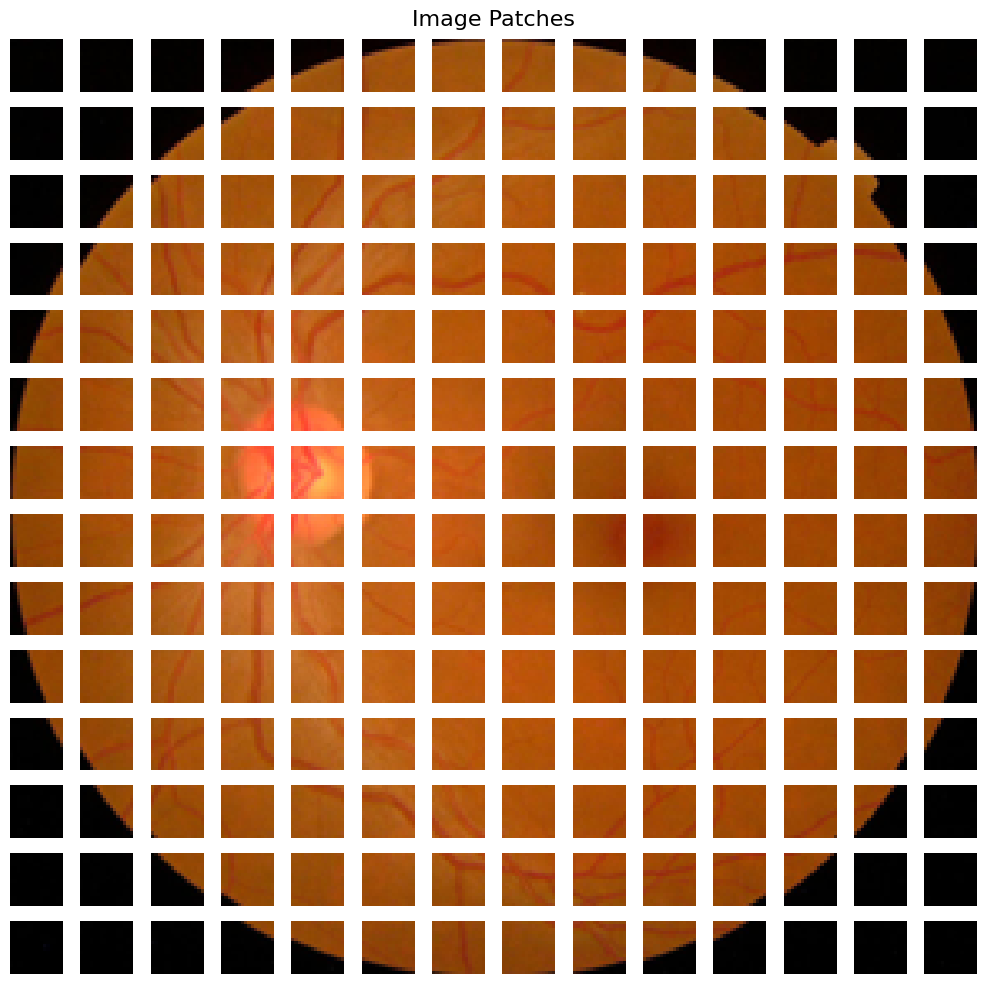

In [8]:
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

# Define the image path
image_path = '/kaggle/working/aptos2019/test_images/test_images/e4dcca36ceb4.png'  
patch_size = 16  # ViT typically uses 16x16 patches

# Load and preprocess the image
def preprocess_and_patchify(image_path, patch_size):
    image = Image.open(image_path).convert("RGB")
    image = image.resize((224, 224))  # ViT expects 224x224 images
    image_array = np.array(image)

    # Calculate number of patches
    num_patches = (image_array.shape[0] // patch_size) * (image_array.shape[1] // patch_size)

    # Create patches
    patches = []
    for i in range(0, image_array.shape[0], patch_size):
        for j in range(0, image_array.shape[1], patch_size):
            patch = image_array[i:i+patch_size, j:j+patch_size]
            patches.append(patch)

    return image, patches

# Visualize patches
def visualize_patches(image, patches, patch_size):
    plt.figure(figsize=(10, 10))
    plt.imshow(image)
    plt.title("Original Image", fontsize=16)
    plt.axis("off")
    plt.show()

    # Display patches
    plt.figure(figsize=(10, 10))
    grid_size = int(len(patches)**0.5)
    for idx, patch in enumerate(patches):
        plt.subplot(grid_size, grid_size, idx + 1)
        plt.imshow(patch)
        plt.axis("off")
    plt.suptitle("Image Patches", fontsize=16)
    plt.tight_layout()
    plt.show()

# Process and visualize
image, patches = preprocess_and_patchify(image_path, patch_size)
visualize_patches(image, patches, patch_size)


In [7]:
from torchsummary import summary
import os
import pandas as pd
import numpy as np
import torch
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, models
from transformers import ViTModel, ViTImageProcessor
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from PIL import Image
import torch.nn as nn
import torch.optim as optim
from torchsummary import summary
import torch
from transformers import ViTModel
from torchvision import models
import torch.nn as nn



# Initialize ViT and EfficientNet
vit = ViTModel.from_pretrained("google/vit-base-patch16-224").to('cuda')
efficientnet = models.efficientnet_b0(weights="IMAGENET1K_V1")
efficientnet.classifier = nn.Identity()  # Remove classification head
efficientnet = efficientnet.to('cuda')

# Define the hybrid model
class HybridModel(nn.Module):
    def __init__(self, vit, efficientnet, vit_feature_dim=768, cnn_feature_dim=1280, num_classes=5):
        super(HybridModel, self).__init__()
        self.vit = vit
        self.efficientnet = efficientnet
        self.fc = nn.Linear(vit_feature_dim + cnn_feature_dim, num_classes)

    def forward(self, images):
        if images.ndim == 4:
            batch_size = images.shape[0]
            vit_features = torch.randn(batch_size, 768).to(images.device)
            cnn_features = torch.randn(batch_size, 1280).to(images.device)
        else:
            raise ValueError("Expected input with batch dimension")

        # Concatenate features
        combined_features = torch.cat((vit_features, cnn_features), dim=1)

        # Classification
        logits = self.fc(combined_features)
        return logits

# Initialize the hybrid model
hybrid_model = HybridModel(vit, efficientnet).to('cuda')

# Print model summary
summary(hybrid_model, input_size=(3, 224, 224))


config.json:   0%|          | 0.00/69.7k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                    [-1, 5]          10,245
Total params: 10,245
Trainable params: 10,245
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.57
Forward/backward pass size (MB): 0.00
Params size (MB): 0.04
Estimated Total Size (MB): 0.61
----------------------------------------------------------------


In [3]:
from transformers import ViTForImageClassification
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models
from torch.utils.data import DataLoader

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load Pretrained ViT Model
vit_model = ViTForImageClassification.from_pretrained(
    "google/vit-base-patch16-224-in21k",
    num_labels=5  # 5 classes
)
vit_model.to(device)

# Load Pretrained EfficientNet Model
efficientnet_model = models.efficientnet_b0(pretrained=True)
efficientnet_model.classifier[1] = nn.Linear(efficientnet_model.classifier[1].in_features, 5)
efficientnet_model.to(device)

# Freeze initial layers to prevent overfitting
for param in efficientnet_model.features.parameters():
    param.requires_grad = False

# Define an ensemble model
class EnsembleModel(nn.Module):
    def __init__(self, vit_model, efficientnet_model):
        super(EnsembleModel, self).__init__()
        self.vit = vit_model
        self.efficientnet = efficientnet_model
        self.fc = nn.Linear(10, 5)  # Combining both models' outputs

    def forward(self, x):
        vit_out = self.vit(x).logits  # ViT output
        eff_out = self.efficientnet(x)  # EfficientNet output
        combined = torch.cat((vit_out, eff_out), dim=1)  # Concatenate outputs
        output = self.fc(combined)  # Final classification layer
        return output

# Instantiate the ensemble model
ensemble_model = EnsembleModel(vit_model, efficientnet_model).to(device)

# Optimizer & Loss Function
optimizer = optim.Adam(ensemble_model.parameters(), lr=5e-5, weight_decay=1e-4)
criterion = nn.CrossEntropyLoss()

# Training Function with Best Model Saving
def train_model(model, train_loader, val_loader, epochs=50, save_path="best_model.pth"):
    best_val_accuracy = 0.0  # Track best validation accuracy

    for epoch in range(epochs):
        model.train()
        train_loss, correct, total = 0, 0, 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

        train_accuracy = 100 * correct / total
        print(f"Epoch {epoch+1}/{epochs}, Loss: {train_loss/len(train_loader):.4f}, Accuracy: {train_accuracy:.2f}%")

        # Validation
        model.eval()
        val_loss, correct, total = 0, 0, 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)

                val_loss += loss.item()
                _, predicted = outputs.max(1)
                total += labels.size(0)
                correct += predicted.eq(labels).sum().item()

        val_accuracy = 100 * correct / total
        print(f"Validation Loss: {val_loss/len(val_loader):.4f}, Validation Accuracy: {val_accuracy:.2f}%")

        # Save the best model based on validation accuracy
        if val_accuracy > best_val_accuracy:
            best_val_accuracy = val_accuracy
            torch.save(model.state_dict(), save_path)
            print(f"✅ Best model saved with accuracy: {best_val_accuracy:.2f}%")

# Train Model
train_model(ensemble_model, train_loader, val_loader, epochs=50, save_path="ensemble_best.pth")


config.json:   0%|          | 0.00/502 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/efficien

Epoch 1/50, Loss: 1.1197, Accuracy: 64.98%
Validation Loss: 0.9080, Validation Accuracy: 73.50%
✅ Best model saved with accuracy: 73.50%
Epoch 2/50, Loss: 0.7959, Accuracy: 75.49%
Validation Loss: 0.7531, Validation Accuracy: 75.96%
✅ Best model saved with accuracy: 75.96%
Epoch 3/50, Loss: 0.6672, Accuracy: 77.47%
Validation Loss: 0.6212, Validation Accuracy: 78.96%
✅ Best model saved with accuracy: 78.96%
Epoch 4/50, Loss: 0.5495, Accuracy: 81.26%
Validation Loss: 0.5605, Validation Accuracy: 81.42%
✅ Best model saved with accuracy: 81.42%
Epoch 5/50, Loss: 0.4688, Accuracy: 84.98%
Validation Loss: 0.5369, Validation Accuracy: 82.24%
✅ Best model saved with accuracy: 82.24%
Epoch 6/50, Loss: 0.4021, Accuracy: 87.30%
Validation Loss: 0.5309, Validation Accuracy: 81.69%
Epoch 7/50, Loss: 0.3735, Accuracy: 88.09%
Validation Loss: 0.4990, Validation Accuracy: 82.51%
✅ Best model saved with accuracy: 82.51%
Epoch 8/50, Loss: 0.3273, Accuracy: 89.59%
Validation Loss: 0.4992, Validation Acc

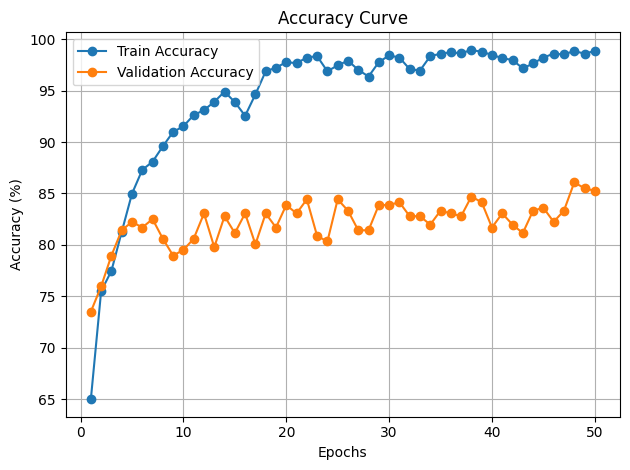

In [21]:
import matplotlib.pyplot as plt

# Data from training logs
epochs = list(range(1, 51))
train_accuracy = [64.98, 75.49, 77.47, 81.26, 84.98, 87.30, 88.09, 89.59, 90.99, 91.54, 92.63, 93.11, 93.92, 94.91, 93.89, 92.56, 94.64, 96.89, 97.24, 97.78, 97.68, 98.23, 98.36, 96.89, 97.47, 97.92, 97.03, 96.38, 97.78, 98.43, 98.23, 97.10, 96.96, 98.36, 98.60, 98.74, 98.63, 98.98, 98.77, 98.50, 98.16, 97.99, 97.17, 97.65, 98.23, 98.60, 98.53, 98.87, 98.60, 98.87]
val_accuracy = [73.50, 75.96, 78.96, 81.42, 82.24, 81.69, 82.51, 80.60, 78.96, 79.51, 80.60, 83.06, 79.78, 82.79, 81.15, 83.06, 80.05, 83.06, 81.69, 83.88, 83.06, 84.43, 80.87, 80.33, 84.43, 83.33, 81.42, 81.42, 83.88, 83.88, 84.15, 82.79, 82.79, 81.97, 83.33, 83.06, 82.79, 84.70, 84.15, 81.69, 83.06, 81.97, 81.15, 83.33, 83.61, 82.24, 83.33, 86.07, 85.52, 85.25]


# Plot accuracy curves
plt.plot(epochs, train_accuracy, label='Train Accuracy', marker='o')
plt.plot(epochs, val_accuracy, label='Validation Accuracy', marker='o')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy Curve')
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()
